In [1]:
from helpers import *
from dataset import *
from model256 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
DEBAG = False
#DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

(5, 184, 630, 630)
(5, 184, 630, 630)


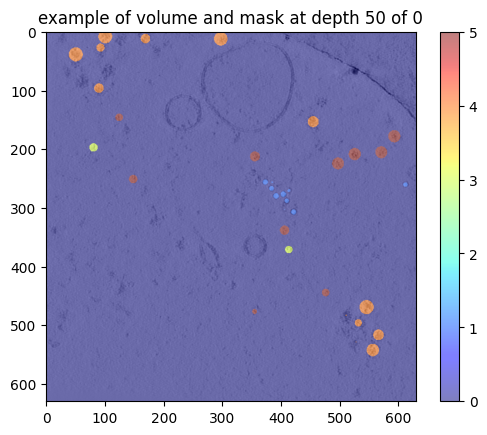

In [4]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4",'TS_99_9']
test_id = ["TS_5_4",'TS_99_9']

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        #y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(valid_id[idx], mask_size)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [5]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)*9

    def __getitem__(self, i):
        idx,seg = i//9,i%9
        seg_x,seg_y = seg//3,seg%3
        idx, start, end = self.indices[idx]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)
        volume = volume[:, seg_x*187:seg_x*187+256, seg_y*187:seg_y*187+256]
        mask   = mask[:, seg_x*187:seg_x*187+256, seg_y*187:seg_y*187+256]

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    #RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])


In [6]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=64, 
    stride=32,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=64, 
    stride=32,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)

225
torch.Size([1, 1, 64, 256, 256]) torch.Size([1, 1, 64, 256, 256])


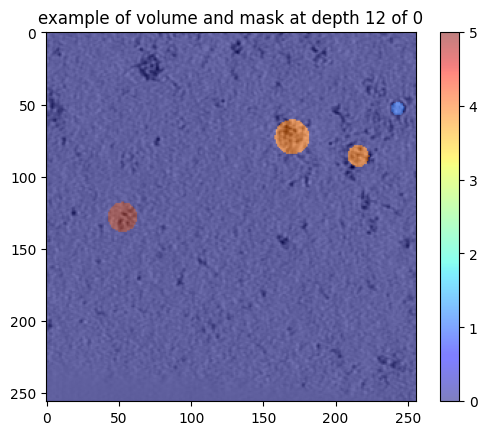

73798
torch.Size([1, 1, 64, 256, 256]) torch.Size([1, 1, 64, 256, 256])


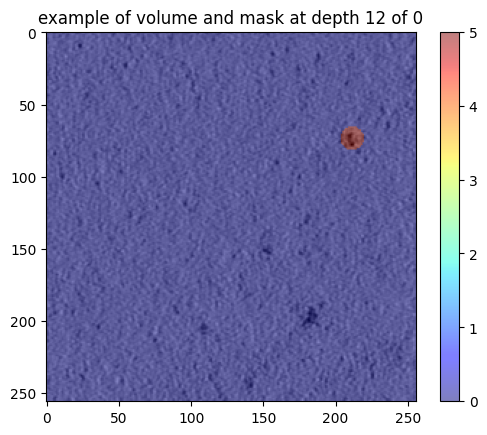

193229


In [7]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [8]:
GPU_ID = 4
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

cuda:4


In [9]:
global train_batch, test_batch

In [10]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn

# 学習ループにCV計算を追加
num_epochs = 100
learning_rate = 1e-3

optimizer = torch.optim.AdamW(
    net.parameters(),
    lr=learning_rate,
    weight_decay=0.01,
    amsgrad=False,
    betas=(0.9, 0.999),
    eps=1e-08,
    capturable=False,
    differentiable=False,
    foreach=None,
    fused=None
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 1

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in range(num_epochs):
    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 不要な次元を削除
        volumes = volumes.squeeze(1)
        masks = masks.squeeze(1)

        # マスクが全て0の場合はスキップ
        if np.sum(masks) == 0:
            continue

        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        # 勾配を毎回リセット
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']  # 勾配累積がないためそのまま使用

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        global_step += 1

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")

    # 5エポックごとにCVスコアを計算
    if epoch % 5 == 0:
        gb, lb_score, mask_loss, probability = evaluate_256cv(net, test_id, cfg, valid_dir, device, mask_size)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア: {lb_score:.4f}")
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    mask_losses.append(np.mean(mask_loss))


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/100
----------
train_loss: 0.9558
valid_loss: 0.6532
CVスコア: 0.0364
         particle_type    P   T  hit  precision    recall  f-beta4
0         apo-ferritin  370  82    0   0.000000  0.000000  0.00000
1         beta-amylase    2  31    0   0.000000  0.000000  0.00000
2   beta-galactosidase  491  36    8   0.016293  0.222222  0.12746
3             ribosome    2  96    0   0.000000  0.000000  0.00000
4        thyroglobulin    2  79    0   0.000000  0.000000  0.00000
5  virus-like-particle    2  24    0   0.000000  0.000000  0.00000
エポック 2/100
----------
train_loss: 0.3421
エポック 3/100
----------
train_loss: 0.1427
エポック 4/100
----------
train_loss: 0.0925
エポック 5/100
----------
train_loss: 0.0734
エポック 6/100
----------
train_loss: 0.0621
valid_loss: 0.0995
CVスコア: 0.0114
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   16  31    0   0.000000  0.000000  0.000000
2   beta-galact

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0551
CVスコア: 0.5689
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   91  36   28   0.307692  0.777778  0.713643
1         beta-amylase   56  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  135  24   14   0.103704  0.583333  0.458574
3             ribosome  205  65   45   0.219512  0.692308  0.614458
4        thyroglobulin  154  49   26   0.168831  0.530612  0.471215
5  virus-like-particle   70  13   13   0.185714  1.000000  0.794964
エポック 42/100
----------
train_loss: 0.0069
エポック 43/100
----------
train_loss: 0.0052
エポック 44/100
----------
train_loss: 0.0047
エポック 45/100
----------
train_loss: 0.0045
エポック 46/100
----------
train_loss: 0.0046
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0582
CVスコア: 0.5637
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  131  36   31   0.236641  0.861111  0.745403
1         beta-amylase   76  21    2   0.026316  0.095238  0.082524
2   beta-galactosidase  181  24   13   0.071823  0.541667  0.391150
3             ribosome  202  65   57   0.282178  0.876923  0.780193
4        thyroglobulin  159  49   24   0.150943  0.489796  0.432662
5  virus-like-particle   78  13   13   0.166667  1.000000  0.772727
エポック 47/100
----------
train_loss: 0.0044
エポック 48/100
----------
train_loss: 0.0039
エポック 49/100
----------
train_loss: 0.0037
エポック 50/100
----------
train_loss: 0.0036
エポック 51/100
----------
train_loss: 0.0043
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0585
CVスコア: 0.6059
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  125  36   27   0.216000  0.750000  0.654779
1         beta-amylase   28  21    4   0.142857  0.190476  0.186813
2   beta-galactosidase  155  24   15   0.096774  0.625000  0.473098
3             ribosome  135  65   59   0.437037  0.907692  0.853617
4        thyroglobulin   92  49   22   0.239130  0.448980  0.426941
5  virus-like-particle   29  13   13   0.448276  1.000000  0.932489
エポック 52/100
----------
train_loss: 0.0034
エポック 53/100
----------
train_loss: 0.0037
エポック 54/100
----------
train_loss: 0.0035
エポック 55/100
----------
train_loss: 0.0031
エポック 56/100
----------
train_loss: 0.0034
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0599
CVスコア: 0.6589
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  123  36   32   0.260163  0.888889  0.778255
1         beta-amylase   34  21    6   0.176471  0.285714  0.275676
2   beta-galactosidase  121  24   15   0.123967  0.625000  0.504950
3             ribosome  137  65   60   0.437956  0.923077  0.866610
4        thyroglobulin  122  49   27   0.221311  0.551020  0.506623
5  virus-like-particle   26  13   13   0.500000  1.000000  0.944444
エポック 57/100
----------
train_loss: 0.0032
エポック 58/100
----------
train_loss: 0.0030
エポック 59/100
----------
train_loss: 0.0033
エポック 60/100
----------
train_loss: 0.0029
エポック 61/100
----------
train_loss: 0.0027
valid_loss: 0.0620
CVスコア: 0.4107
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  141  82   32   0.226950  0.390244  0.374398
1         beta-amylase   27  31    6   0.222222  0.193548  0.195029
2   beta-galactosidase  150  36   16   0.106

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0627
CVスコア: 0.6028
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  121  36   28   0.231405  0.777778  0.682927
1         beta-amylase   29  21    4   0.137931  0.190476  0.186301
2   beta-galactosidase  119  24   11   0.092437  0.458333  0.371769
3             ribosome  128  65   59   0.460938  0.907692  0.858733
4        thyroglobulin  109  49   26   0.238532  0.530612  0.494961
5  virus-like-particle   26  13   13   0.500000  1.000000  0.944444
エポック 67/100
----------
train_loss: 0.0024
エポック 68/100
----------
train_loss: 0.0022
エポック 69/100
----------
train_loss: 0.0029
エポック 70/100
----------
train_loss: 0.0028
エポック 71/100
----------
train_loss: 0.0024
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0636
CVスコア: 0.5890
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  120  36   31   0.258333  0.861111  0.757184
1         beta-amylase   71  21    6   0.084507  0.285714  0.250614
2   beta-galactosidase  107  24   12   0.112150  0.500000  0.415479
3             ribosome  176  65   57   0.323864  0.876923  0.796875
4        thyroglobulin   88  49   22   0.250000  0.448980  0.428899
5  virus-like-particle   43  13   13   0.302326  1.000000  0.880478
エポック 72/100
----------
train_loss: 0.0027
エポック 73/100
----------
train_loss: 0.0025
エポック 74/100
----------
train_loss: 0.0022
エポック 75/100
----------
train_loss: 0.0021
エポック 76/100
----------
train_loss: 0.0020
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0702
CVスコア: 0.5654
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   98  36   36   0.367347  1.000000  0.908012
1         beta-amylase   51  21    7   0.137255  0.333333  0.307494
2   beta-galactosidase   82  24   10   0.121951  0.416667  0.364807
3             ribosome  144  65   56   0.388889  0.861538  0.804054
4        thyroglobulin   58  49   13   0.224138  0.265306  0.262470
5  virus-like-particle   15  13   13   0.866667  1.000000  0.991031
エポック 77/100
----------
train_loss: 0.0021
エポック 78/100
----------
train_loss: 0.0020
エポック 79/100
----------
train_loss: 0.0023
エポック 80/100
----------
train_loss: 0.0023
エポック 81/100
----------
train_loss: 0.0021
valid_loss: 0.0686
CVスコア: 0.3741
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   87  82   33   0.379310  0.402439  0.401001
1         beta-amylase   96  31    6   0.062500  0.193548  0.172297
2   beta-galactosidase  125  36   14   0.112

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0705
CVスコア: 0.6249
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   92  36   35   0.380435  0.972222  0.890719
1         beta-amylase   42  21    6   0.142857  0.285714  0.269841
2   beta-galactosidase  113  24   12   0.106195  0.500000  0.410463
3             ribosome  115  65   58   0.504348  0.892308  0.853680
4        thyroglobulin   84  49   21   0.250000  0.428571  0.411290
5  virus-like-particle   16  13   13   0.812500  1.000000  0.986607
エポック 92/100
----------
train_loss: 0.0017
エポック 93/100
----------
train_loss: 0.0016
エポック 94/100
----------
train_loss: 0.0017
エポック 95/100
----------
train_loss: 0.0018
エポック 96/100
----------
train_loss: 0.0017
valid_loss: 0.0728
CVスコア: 0.3797
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  103  82   35   0.339806  0.426829  0.420495
1         beta-amylase   82  31    7   0.085366  0.225806  0.205882
2   beta-galactosidase  134  36   14   0.104

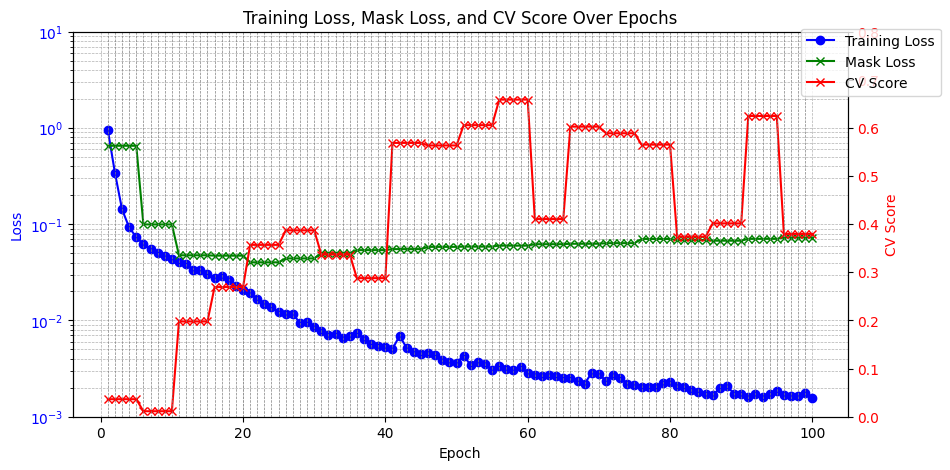

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [12]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

NameError: name 'mask_size2' is not defined

In [ ]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.05)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[1,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')